This notebook aims to use Machine Learning methods in the Update process of System Literature Reviews.
We take input from the Training dataset, while the results of 1 round of Forward Snowballing serve as the Testing dataset.
We use text preprocessing and natural language processing to process the datasets. 
Four ML algorithms have been experimented with for text classification:
- Stochastic gradient descent
- XG Boost
- Logistic Regression
- Multinomial Naive Bayes

Importing libraries for NLP, Machine learning, and Vizzes

In [1]:
import pandas as pd

import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

In [2]:
import nltk
from nltk.corpus import stopwords
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from wordcloud import WordCloud, STOPWORDS
import spacy

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading the Training and Testing data 

In [4]:
df_train = pd.read_csv('/content/drive/MyDrive/Mitacs study material/SLR Update Experiment/Data/Training.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Mitacs study material/SLR Update Experiment/Data/Testing-test.csv')

Reading the actual included studies to be validated

In [5]:
df_ones = pd.read_csv('/content/drive/MyDrive/Mitacs study material/SLR Update Experiment/Data/Testing.csv')

In [6]:
df_train.head()

,Title,Abstract,Relevance
0,Structuring automotive product lines and featu...,Automotive systems are highly complex and cust...,0
1,Using Scrum in Outsourced Government Projects:...,The growth in popularity of Agile methods plus...,0
2,Interventions for Software Security: Creating ...,Though some software development teams are hig...,0
3,Sustainability analysis and ease of learning i...,Context: Artifact-based requirements engineeri...,0
4,Light-Touch Interventions to Improve Software ...,Many software developers still have little int...,0


In [7]:
df_test.head()

,Title,Abstract,Relevance
0,Using Scrum in Outsourced Government Projects:...,The growth in popularity of Agile methods plus...,0
1,Academic and Industrial Software Testing Confe...,"Just as with any other profession, an efficien...",0
2,Light-Touch Interventions to Improve Software ...,Many software developers still have little int...,0
3,Interventions for Software Security: Creating ...,Though some software development teams are hig...,0
4,Measuring and Improving Agile Processes in a S...,Context: Agile software development has become...,0


In [9]:
# df_ones.head()

Remove any duplicate entries from forward snowballing

In [10]:
df_train.drop_duplicates(inplace=True)

Visualizing class distribution

<AxesSubplot:xlabel='Relevance'>

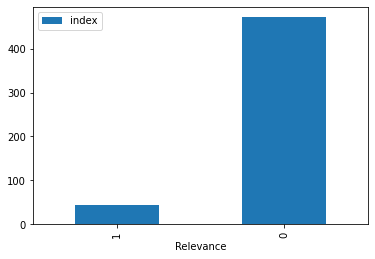

In [11]:
df_train["Relevance"].reset_index().groupby("Relevance").count().sort_values(by="index").plot(kind="bar") # training set is moderately unbalanced

In [12]:
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [ ]:
# df_test = df_test.sample(frac=1).reset_index(drop=True)

Removing duplicates for the test set

In [13]:
df_test.drop_duplicates(inplace=True)

Test set data distribution

<AxesSubplot:xlabel='Relevance'>

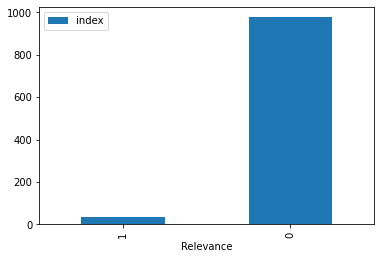

In [70]:
df_test["Relevance"].reset_index().groupby("Relevance").count().sort_values(by="index").plot(kind="bar") # test set is highly unbalanced

In [14]:
df_train.dtypes 

Title        object
Abstract     object
Relevance     int64
dtype: object

In [15]:
df_test.dtypes

Title        object
Abstract     object
Relevance     int64
dtype: object

Checking NaN values

In [16]:
df_train.isnull().sum() # nan values

Title        0
Abstract     0
Relevance    0
dtype: int64

In [17]:
df_test.isnull().sum() # nan values

Title          1
Abstract     207
Relevance      0
dtype: int64

In [20]:
# df_ones.isnull().sum()

In [19]:
df_train = df_train.reset_index(drop=True)
df_train.tail()

,Title,Abstract,Relevance
511,Practical Experiences in Designing and Conduct...,"More and more, software engineering researcher...",1
512,A structured approach to academic technology t...,"In this article, we describe imec?s 101 Progra...",0
513,Collaborative research project networks: Knowl...,Many businesses seeking enhanced innovation ha...,0
514,Enablers and Impediments for Collaborative Res...,"When it comes to industrial organizations, cur...",1
515,"Models, processes, and roles of universities i...",Universities play pivotal roles when research ...,0


In [21]:
df_test = df_test.reset_index(drop=True)
df_test.tail()

,Title,Abstract,Relevance
1007,International Scientific Collaboration in Arti...,NaN,0
1008,Applying Action Design Research ({ADR}) to Dev...,NaN,0
1009,Predicting coauthorship using bibliographic ne...,Coauthorship prediction applies predictive ana...,0
1010,Making design research relevant for design pra...,Knowledge from academic design research projec...,0
1011,From Theory to Practice{\textemdash}When and H...,NaN,0


In [22]:
df_train.shape, df_test.shape, df_ones.shape

((516, 3), (1012, 3), (35, 3))

Removing nan values

In [23]:
df_train['Abstract'] = df_train['Abstract'].fillna(' ')

Merging the Title and Abstract

In [24]:

df_train["Merged"] = df_train["Title"] + df_train["Abstract"]

In [25]:
df_train.head()

,Title,Abstract,Relevance,Merged
0,Bridging the Industry-Academia Collaboration G...,Industry-Academia collaboration is much necess...,0,Bridging the Industry-Academia Collaboration G...
1,The Management of University--Industry Collabo...,In this chapter we will discuss some of the pr...,1,The Management of University--Industry Collabo...
2,Observations from the Industry-as-Laboratory R...,"In 1993, Potts observed that research done usi...",1,Observations from the Industry-as-Laboratory R...
3,A Critical View on PLM/ALM Convergence in Prac...,The Internet of Things (IoT) is the main drive...,0,A Critical View on PLM/ALM Convergence in Prac...
4,Critical success factors (CSFs) in university-...,This research study examines the CSFs in UIC t...,0,Critical success factors (CSFs) in university-...


In [26]:
df_train.isnull().sum()

Title        0
Abstract     0
Relevance    0
Merged       0
dtype: int64

Handling Nan values and merging the title-abstract for test set

In [27]:
df_test['Title'] = df_test['Title'].fillna(' ')
df_test['Abstract'] = df_test['Abstract'].fillna(' ')
df_test["Merged"] = df_test["Title"] + df_test["Abstract"]

In [28]:
df_test.head()

,Title,Abstract,Relevance,Merged
0,Using Scrum in Outsourced Government Projects:...,The growth in popularity of Agile methods plus...,0,Using Scrum in Outsourced Government Projects:...
1,Academic and Industrial Software Testing Confe...,"Just as with any other profession, an efficien...",0,Academic and Industrial Software Testing Confe...
2,Light-Touch Interventions to Improve Software ...,Many software developers still have little int...,0,Light-Touch Interventions to Improve Software ...
3,Interventions for Software Security: Creating ...,Though some software development teams are hig...,0,Interventions for Software Security: Creating ...
4,Measuring and Improving Agile Processes in a S...,Context: Agile software development has become...,0,Measuring and Improving Agile Processes in a S...


In [29]:
df_test.isnull().sum()

Title        0
Abstract     0
Relevance    0
Merged       0
dtype: int64

In [ ]:
### for marking the titles present in testing.csv as 1 in testing-test relevance. but exact match is leaving out many, so done manually
# l = 0
# indices=[]
# for i in range(df_ones.shape[0]):
#   # print(df_ones.loc[i,'Title'])
#   t = df_ones.loc[i,'Title']
#   test = df_test['Title']
#   if t in list(test):
#     l+=1
#     index = np.where(test==t)[0][0]
#     print(index)
#     indices.append(index)
#     # print(df_test.iloc[index])
#     print(t)
# df_test.loc[indices,'Relevance'] = int(1)
# print(l)

108
Meeting Industry-Academia Research Collaboration Challenges with Agile Methodologies
53
Leveraging organizational climate theory for understanding industry-academia collaboration
19
Characterizing industry-academia collaborations in software engineering: evidence from 101 projects
28
Industry-Academia research collaboration in software engineering: The Certus model
45
Knowledge Management in University-Software Industry Collaboration
60
Lessons Learned on Research Co-Creation: Making Industry-Academia Collaboration Work
75
Planning for the Unknown: Lessons Learned from Ten Months of Non-participant Exploratory Observations in the Industry
84
University-software industry collaboration: an empirical study based on knowledge management
81
Generative Modeling Games for Exploratory Industry-Academic Research
146
Recruitment, engagement and feedback in empirical software engineering studies in industrial contexts
192
Continuous and collaborative technology transfer: Software engineering 

In [29]:
# df_test['Relevance'] = df_test['Relevance'].astype('int')

In [30]:
df_test.loc[18,'Relevance']

0

In [31]:
df_test.dtypes

Title        object
Abstract     object
Relevance     int64
Merged       object
dtype: object

Checking the frequency of each class in test set

In [32]:
df_test.groupby('Relevance').count()

,Title,Abstract,Merged
Relevance,,,
0,977,977,977
1,35,35,35


Splitting into Features and Labels for training and testing

In [33]:
X_train = df_train["Merged"]
y_train = df_train["Relevance"]

In [34]:
X_test = df_test["Merged"]
y_test = df_test["Relevance"]

In [35]:
X_train = X_train.astype(str)

In [36]:
X_test = X_test.astype(str) 

In [37]:
X_train

0      Bridging the Industry-Academia Collaboration G...
1      The Management of University--Industry Collabo...
2      Observations from the Industry-as-Laboratory R...
3      A Critical View on PLM/ALM Convergence in Prac...
4      Critical success factors (CSFs) in university-...
                             ...                        
511    Practical Experiences in Designing and Conduct...
512    A structured approach to academic technology t...
513    Collaborative research project networks: Knowl...
514    Enablers and Impediments for Collaborative Res...
515    Models, processes, and roles of universities i...
Name: Merged, Length: 516, dtype: object

In [38]:
X_test

0       Using Scrum in Outsourced Government Projects:...
1       Academic and Industrial Software Testing Confe...
2       Light-Touch Interventions to Improve Software ...
3       Interventions for Software Security: Creating ...
4       Measuring and Improving Agile Processes in a S...
                              ...                        
1007    International Scientific Collaboration in Arti...
1008    Applying Action Design Research ({ADR}) to Dev...
1009    Predicting coauthorship using bibliographic ne...
1010    Making design research relevant for design pra...
1011    From Theory to Practice{\textemdash}When and H...
Name: Merged, Length: 1012, dtype: object

Text Preprocessing

In [39]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Stopwords removal

In [40]:

def remove_stopwords(x):
    cap = x.split()
    cap = [w.lower() for w in cap]
    cap = [w for w in cap if w not in stopwords.words('english')]
    cap = [w for w in cap if w not in string.punctuation]
    return ' '.join(cap)


X_train = X_train.apply(remove_stopwords)

Tokenisation

In [41]:

def reduce_count(st):
    words = st.split()
    chars = ['-','.','&','=']
    for char in string.punctuation:
        words = [w for w in words if char not in w]
    words = [w for w in words if 5000 > tokenizer.word_counts[w] > 10]
    words.insert(0,'startseq')
    words.append('endseq')
    words = ' '.join(words)
    
    return words

for i in range(2):
    tokenizer = Tokenizer(oov_token='OOV')
    tokenizer.fit_on_texts(X_train)
    X_train = X_train.apply(reduce_count)
    tokenizer = Tokenizer(oov_token='OOV')
    tokenizer.fit_on_texts(X_train)

Remove punctuation

In [42]:

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

X_train = X_train.apply(lambda text: remove_punctuation(text))

Remove urls

In [43]:

import re
def removeurls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

X_train = X_train.apply(lambda text: removeurls(text))

X_train

0      startseq startseq collaboration gap focus towa...
1      startseq startseq management collaborations in...
2      startseq startseq observations research projec...
3      startseq startseq critical view practice main ...
4      startseq startseq critical success factors col...
                             ...                        
511    startseq startseq practical experiences design...
512    startseq startseq structured approach academic...
513    startseq startseq collaborative research proje...
514    startseq startseq enablers collaborative resea...
515    startseq startseq roles universities technolog...
Name: Merged, Length: 516, dtype: object

Lemmatisation

In [44]:
nlp = spacy.load('en_core_web_sm')
nlp.disable_pipes('ner', 'parser')

def space(review):
    doc = nlp(review)
    return " ".join([token.lemma_ for token in doc])

X_train = X_train.apply(space)
X_train

0      startseq startseq collaboration gap focus towa...
1      startseq startseq management collaboration inv...
2      startseq startseq observation research project...
3      startseq startseq critical view practice main ...
4      startseq startseq critical success factor coll...
                             ...                        
511    startseq startseq practical experience design ...
512    startseq startseq structure approach academic ...
513    startseq startseq collaborative research proje...
514    startseq startseq enabler collaborative resear...
515    startseq startseq role university technology t...
Name: Merged, Length: 516, dtype: object

Vectorizer (n-gram)

In [45]:
#Vectorisation and Tokenisation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
cv.fit(X_train)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(stop_words='english',
                tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)

In [46]:
text_counts = cv.transform(X_train)

Repeat above processing on Test set


In [47]:
X_test = X_test.apply(remove_stopwords)

for i in range(2):
    tokenizer = Tokenizer(oov_token='OOV')
    tokenizer.fit_on_texts(X_test)
    X_test = X_test.apply(reduce_count)
    tokenizer = Tokenizer(oov_token='OOV')
    tokenizer.fit_on_texts(X_test)

X_test = X_test.apply(lambda text: remove_punctuation(text))

X_test = X_test.apply(lambda text: removeurls(text))

X_test = X_test.apply(space)


In [48]:
test_text_counts = cv.transform(X_test)

In [49]:
X_test

0       startseq startseq use government action growth...
1       startseq startseq academic industrial software...
2       startseq startseq intervention improve softwar...
3       startseq startseq intervention software create...
4       startseq startseq improve agile process softwa...
                              ...                        
1007    startseq startseq international scientific col...
1008    startseq startseq apply action design research...
1009    startseq startseq use bibliographic network pr...
1010    startseq startseq make design research relevan...
1011    startseq startseq theory implement service val...
Name: Merged, Length: 1012, dtype: object

### XGBoost 

Model Training

In [479]:
import xgboost as xgb
xgb = xgb.XGBClassifier(subsample=0.2,gamma =20,scale_pos_weight=977/35)
xgb.fit(text_counts, y_train)

XGBClassifier(gamma=20, scale_pos_weight=27.914285714285715, subsample=0.2)

Training accuracy

In [480]:
xgb.score(text_counts, y_train)

0.8817829457364341

In [481]:
from sklearn import metrics
print(metrics.classification_report(xgb.predict(text_counts), y_train))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       410
           1       1.00      0.42      0.60       106

    accuracy                           0.88       516
   macro avg       0.94      0.71      0.76       516
weighted avg       0.90      0.88      0.86       516



Prediction on Test set

In [482]:
predicted = xgb.predict(test_text_counts)
accuracy_score = metrics.accuracy_score(predicted, y_test)
accuracy_score

0.8280632411067194

In [483]:
print(metrics.classification_report(predicted, y_test)) # the order of the input for results in the paper is (y_test, predicted)

              precision    recall  f1-score   support

           0       0.84      0.98      0.90       831
           1       0.60      0.12      0.19       181

    accuracy                           0.83      1012
   macro avg       0.72      0.55      0.55      1012
weighted avg       0.79      0.83      0.78      1012



Confusion matrix

<AxesSubplot:>

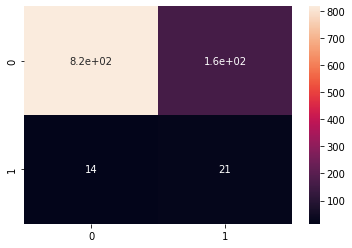

In [484]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix,annot=True)

### SGD  

Model training

In [224]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(alpha=2, class_weight='balanced')
sgd.fit(text_counts, y_train)

SGDClassifier(alpha=2, class_weight='balanced')

Training accuracy

In [225]:
sgd.score(text_counts, y_train)

0.8468992248062015

In [226]:
from sklearn import metrics
print(metrics.classification_report(sgd.predict(text_counts), y_train))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       394
           1       0.98      0.36      0.53       122

    accuracy                           0.85       516
   macro avg       0.91      0.68      0.72       516
weighted avg       0.87      0.85      0.82       516



Prediction on the Test set

In [227]:
predicted = sgd.predict(test_text_counts)
accuracy_score = metrics.accuracy_score(predicted, y_test)
accuracy_score

0.8389328063241107

In [228]:
print(metrics.classification_report(predicted, y_test)) # the order of the input for results in the paper is (y_test, predicted)

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       832
           1       0.74      0.14      0.24       180

    accuracy                           0.84      1012
   macro avg       0.79      0.57      0.58      1012
weighted avg       0.82      0.84      0.79      1012



Confusion matrix

<AxesSubplot:>

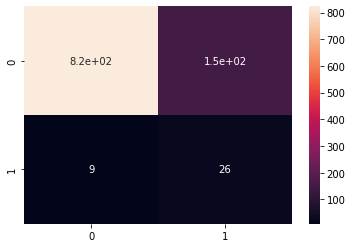

In [229]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix,annot=True)

### Logistic Reg

Model training

In [126]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.01, class_weight='balanced')
lr.fit(text_counts, y_train)

LogisticRegression(C=0.01, class_weight='balanced')

Training Accuracy

In [127]:
lr.score(text_counts, y_train)

0.9186046511627907

In [128]:
from sklearn import metrics
print(metrics.classification_report(lr.predict(text_counts), y_train))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       429
           1       1.00      0.52      0.68        87

    accuracy                           0.92       516
   macro avg       0.96      0.76      0.82       516
weighted avg       0.93      0.92      0.91       516



Prediction on the test set

In [129]:
predicted = lr.predict(test_text_counts)
accuracy_score = metrics.accuracy_score(predicted, y_test) 
accuracy_score

0.8903162055335968

In [130]:
print(metrics.classification_report(predicted, y_test)) # the order of the input for results in the paper is (y_test, predicted)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       906
           1       0.43      0.14      0.21       106

    accuracy                           0.89      1012
   macro avg       0.67      0.56      0.58      1012
weighted avg       0.86      0.89      0.86      1012



Confusion matrix

<AxesSubplot:>

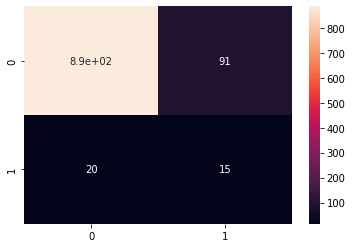

In [131]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix,annot=True)

### Multinomial NB

In [ ]:
from sklearn import metrics

Model training

In [62]:
from sklearn.naive_bayes import MultinomialNB
#Multinomial Naive Bayes
MNB = MultinomialNB()
MNB.fit(text_counts, y_train)

MultinomialNB()

Training accuracy

In [63]:
MNB.score(text_counts, y_train)

0.9263565891472868

In [64]:
print(metrics.classification_report(MNB.predict(text_counts), y_train))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       437
           1       0.96      0.54      0.69        79

    accuracy                           0.93       516
   macro avg       0.94      0.77      0.83       516
weighted avg       0.93      0.93      0.92       516



Prediction on the Test set

In [65]:
predicted = MNB.predict(test_text_counts)
accuracy_score = metrics.accuracy_score(predicted, y_test)
accuracy_score

0.9051383399209486

In [68]:
print(metrics.classification_report(predicted, y_test)) # the order of the input for results in the paper is (y_test, predicted)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       923
           1       0.40      0.16      0.23        89

    accuracy                           0.91      1012
   macro avg       0.66      0.57      0.59      1012
weighted avg       0.88      0.91      0.89      1012



Confusion matrix

<AxesSubplot:>

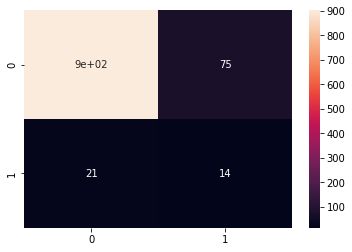

In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predicted)
sns.heatmap(cf_matrix,annot=True)

Best model (in the descending order of Recall score):
1. SGD
2. XGBoost
3. Logistic Regression
4. Multinomial Naive Bayes